# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [3]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [4]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        # Место для вашего кода
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name='w')
        self.b = tf.Variable(tf.zeros([out_features]), name='b')
    
    def __call__(self, x):
        # Место для вашего кода
        y = tf.matmul(x, self.w) + self.b
        
        return tf.nn.sigmoid(y)


class NN(tf.Module):
    def __init__(self, input_size, sizes, name=None):
        super().__init__(name=name)
        # Место для вашего кода
        self.layers = []
        with self.name_scope:
            for size in sizes:
                self.layers.append(DenseLayer(in_features=input_size, out_features=size))
                input_size = size
    
    @tf.Module.with_name_scope
    def __call__(self, x):
        # Место для вашего кода
        for layer in self.layers:
            x = layer(x)
            
        return tf.nn.softmax(x)

In [5]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    # Место для вашего кода
    accuracy_metric = tf.keras.metrics.Accuracy()
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    accuracy_metric.update_state(y_true, y_pred_labels)
    
    return accuracy_metric.result().numpy()

In [6]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist", input_size=x_train.shape[1], sizes=[n_hidden_1, n_hidden_2, num_classes])

# Функция обучения нейросети
def train(nn, input_x, output_y):
    # Для подгонки весов сети будем использовать стохастический градиентный спуск
    optimizer = tf.optimizers.SGD(learning_rate)

    # Активация автоматического дифференцирования
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)
        
    # Создадим оптимизируемых список параметров
    # Вычислим по ним значение градиента
    # Модифицируем параметры
    # Место для вашего кода
    gradients = g.gradient(loss, nn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, nn.trainable_variables))
    
    return loss

In [7]:
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором 
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (x_batch, y_batch) in enumerate(train_data.take(training_steps)):
    # Место для вашего кода
    train(neural_net, x_batch, y_batch)
    
    if step % display_step == 0:
        pred = neural_net(x_batch)
    
        loss = cross_entropy(pred, y_batch)
        loss_history.append(loss)
        
        accuracy_ = accuracy(pred, y_batch)
        accuracy_history.append(accuracy_)
        
        print(f'Step: {step} | Loss: {loss} | Accuracy: {accuracy_}')

Step: 0 | Loss: 600.760986328125 | Accuracy: 0.10546875
Step: 100 | Loss: 572.4222412109375 | Accuracy: 0.09765625
Step: 200 | Loss: 548.5816650390625 | Accuracy: 0.1328125
Step: 300 | Loss: 519.1783447265625 | Accuracy: 0.140625
Step: 400 | Loss: 504.454833984375 | Accuracy: 0.15625
Step: 500 | Loss: 498.7122802734375 | Accuracy: 0.15625
Step: 600 | Loss: 491.9489440917969 | Accuracy: 0.28125
Step: 700 | Loss: 465.8114013671875 | Accuracy: 0.46875
Step: 800 | Loss: 465.38623046875 | Accuracy: 0.578125
Step: 900 | Loss: 462.55438232421875 | Accuracy: 0.6015625
Step: 1000 | Loss: 450.1246337890625 | Accuracy: 0.6875
Step: 1100 | Loss: 449.19512939453125 | Accuracy: 0.6875
Step: 1200 | Loss: 443.23016357421875 | Accuracy: 0.7265625
Step: 1300 | Loss: 440.709716796875 | Accuracy: 0.75
Step: 1400 | Loss: 433.83807373046875 | Accuracy: 0.75
Step: 1500 | Loss: 440.8570556640625 | Accuracy: 0.71875
Step: 1600 | Loss: 431.33697509765625 | Accuracy: 0.7890625
Step: 1700 | Loss: 430.965881347656

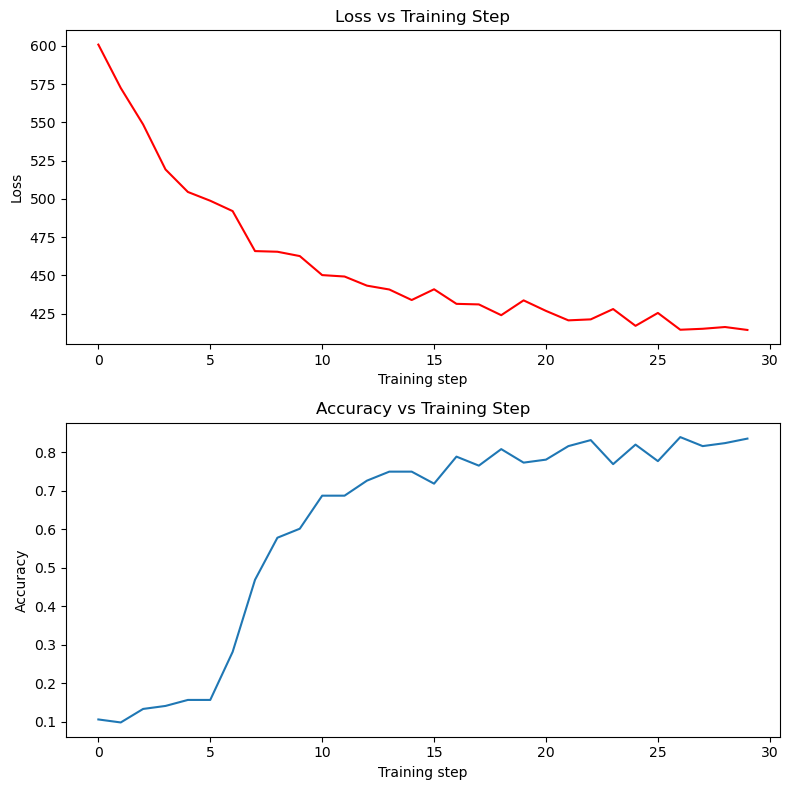

In [8]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

ax1.plot(loss_history, color='red')
ax1.set_xlabel('Training step')
ax1.set_ylabel('Loss')
ax1.set_title('Loss vs Training Step')

ax2.plot(accuracy_history)
ax2.set_xlabel('Training step')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy vs Training Step')

plt.tight_layout()
plt.show()

In [9]:
# Вычислите точность обученной нейросети
pred = neural_net(x_test)
acc = accuracy(pred, y_test)
acc

0.8162

In [10]:
test_sample = np.random.choice(range(len(x_test)), size=10, replace=False)
test_images = x_test[test_sample]
test_labels = y_test[test_sample]

pred_test = neural_net(test_images)

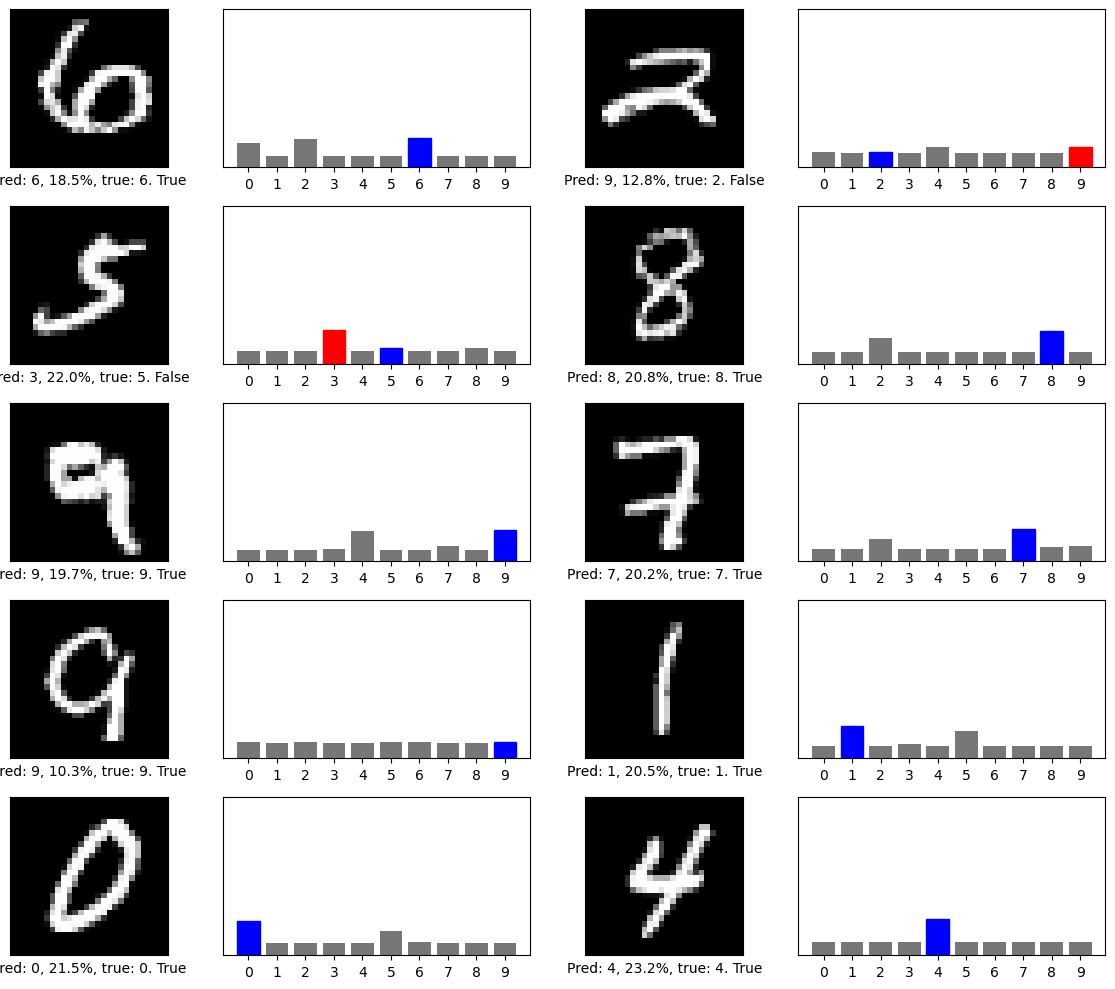

In [11]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5 
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?
def plot_image(i, predictions, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = img.reshape((28, 28))
    
    plt.imshow(img, cmap='gray')
    
    predicted_label = np.argmax(predictions)

    plt.xlabel(f'Pred: {predicted_label}, {round(100*np.max(predictions), 1)}%, true: {true_label}. {predicted_label == true_label}')

    
def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color='#777777')
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')
    

num_rows = 5
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(3*2*num_cols, 2*num_rows))

for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, pred_test[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, pred_test[i], test_labels)
plt.tight_layout()
plt.show()

According to the pictures and to the accuracy rate this neural network makes mistakes in 2 examples out of 10.